<h1>Vehicle Tracking</h1>

Solution Video: https://www.youtube.com/watch?v=OvadpMIeJMg

Below are the steps taken for implementing the fifth SDNC project

<h2>Step 1: Imports</h2>
I extracted a few images myself from the frames given in the test video of the car and the road. Along with those images, I used both the KITTI vision benchmark suite and the GTI vehicle image database. I also imported the few packages I used for this assignment.

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
%matplotlib inline

root = 'C:\\Users\\Syed\\Documents\\Proj5\\test_images\\'
car_pre = 'vehicles\\'
not_car_pre = 'non-vehicles\\'
##The 'Car' and 'Notcar' directories are the ones I extracted myself
car_dir = ['GTI_Far\\', 'GTI_Left\\', 'GTI_MiddleClose\\', 'GTI_Right\\', 'KITTI_extracted\\', 'Car\\']
not_car_dir = ['Extras\\','GTI\\','Notcar\\']

cars = []
notcars = []

for folder in car_dir:
    files = glob.glob(root + car_pre + folder + '*.png')
    cars = cars + files
    
for folder in not_car_dir:
    files = glob.glob(root + not_car_pre + folder + '*.png')
    notcars = notcars + files

<h2>Step 2: Setting the Parameters</h2>
The following parameters were used throughout the assignment. These are parameters I tweaked to get the result which I found to work best for me. From the original code provided by Udacity, I found that I wasn't in need of the spatial or histogram features, hence got rid of those. I tried all the color spaces, but found HSV worked best for me. I also played around with the number of hog channels and found that when I included all of them, I was given the best result in terms of my accuracy in classifying. The results are displayed below.

In [2]:
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
hog_feat = True # HOG features on or off

<h2>Step 3: Extracting Features</h2>
Extracting the features from an image (or many images) can be breaken into many substeps. These substeps are listed below:

1 - Using OpenCV's cvtcolor function, convert images to your desired color space (which in this case is HSV)

2 - Making use of Scikit-Image's hog function and the images ouputted in the above substep, extract their hog feetures and images from them.

In [3]:
def extract_features(imgs, color_space='HSV', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL', hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        # Convert the image to HSV
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)     
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [4]:
car_features = extract_features(cars, color_space=color_space,  
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space,  
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, hog_feat=hog_feat)

<h3>Example of extracted HOG Images</h3>
Below are a few examples of the results received after extracting the HOG images. 

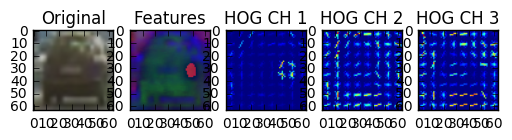

In [9]:
def hogs_example(path, hog_channel, orient, pix_per_cell, cell_per_block):
    img = cv2.imread(path)
    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hog_image = []
    if hog_channel == 'ALL':
        for channel in range(feature_image.shape[2]): 
            features, hog_img = get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            hog_image.append(hog_img)
    return img, feature_image, hog_image

rand_state = np.random.randint(0, 100)
car_img, car_feat_image, car_hog = hogs_example(cars[rand_state], hog_channel, orient, pix_per_cell, cell_per_block)
notcar_img, notcar_feat_image, notcar_hog = hogs_example(notcars[rand_state], hog_channel, orient, pix_per_cell, cell_per_block)

plt.subplot(151)
plt.imshow(car_img)
plt.title('Original')
plt.subplot(152)
plt.imshow(car_feat_image)
plt.title('Features')
plt.subplot(153)
plt.imshow(car_hog[0])
plt.title('HOG CH 1')
plt.subplot(154)
plt.imshow(car_hog[1])
plt.title('HOG CH 2')
plt.subplot(155)
plt.imshow(car_hog[2])
plt.title('HOG CH 3')

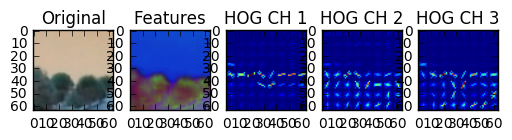

In [10]:
plt.subplot(151)
plt.imshow(notcar_img)
plt.title('Original')
plt.subplot(152)
plt.imshow(notcar_feat_image)
plt.title('Features')
plt.subplot(153)
plt.imshow(notcar_hog[0])
plt.title('HOG CH 1')
plt.subplot(154)
plt.imshow(notcar_hog[1])
plt.title('HOG CH 2')
plt.subplot(155)
plt.imshow(notcar_hog[2])
plt.title('HOG CH 3')

<h2>Step 4: Training the Model</h2>
After extracting the features for both images which are cars and not cars, and before actually training the model, the images were standardized. The reason we standardize is to make sure the data looks more or less like it's normally distributed and that they can be better used when using the SVC (support vector classifier). This was done with the help of Scikit Learn's StandarScaler and transform functions.

Before training the model, the data was split into training and testing sets. The Linear SVC was used to model was used in order to classify between cars (1) and not cars (0).

In [11]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

#Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
svc.fit(X_train, y_train)
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
Test Accuracy of SVC =  0.9833
My SVC predicts:  [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  1.]
For these 10 labels:  [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  1.]


<h2>Model Results</h2>
As you can see, the accuracy given for the model is about 98%. For when actually using my model, I don't split into training and testing sets, rather I use all the images that I have. The output is what can be seen in the video. It allows the model to have more data to further train it.

In [12]:
svc = LinearSVC()
svc.fit(scaled_X, y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

<h2>Step 5: Processing the Image</h2>
Processing the image taken from the video can be split into multiple substeps - splitting the image into window sections; finding the "hot" windows; remove false positives.

1 - When it came to splitting the image window into sections, I only used the bottom half of the image, because the top half was the sky, and the right half of the image, because I didn't care to detect cars on the on coming traffic side. After that, I split the remaining portion of the picture into several segments. I went through the video and cropped out different images of the car to see what kind of sizes can I expect to find a car, in terms of pixels. Found that I found about 4 sizes which could generalize into roughly what sizes the cars appear in the video. The sizes were: 110x60 pixels, 130x90 pixels, 220x130 pixels and 400x220 pixels. I used those to be my window sizes and put them througout the image so I could be sure that I would catch the whole car in a single window, no matter what the size. Please see my output for the cell below to see my window sizes

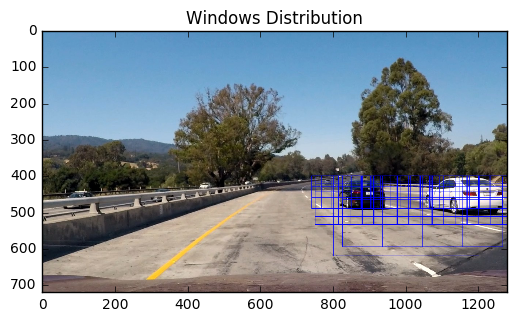

In [13]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

image = mpimg.imread(root+'test1.jpg')

draw_image = np.copy(image)

windows = slide_window(image, x_start_stop=[740, 1275], y_start_stop=[400, 460], 
                xy_window=(110, 60), xy_overlap=(0.75, 0.75))   
windows += slide_window(image, x_start_stop=[750, 1275], y_start_stop=[400, 490], 
                xy_window=(130, 90), xy_overlap=(0.75, 0.75))
windows += slide_window(image, x_start_stop=[825, 1275], y_start_stop=[400, 600], 
                xy_window=(220, 130), xy_overlap=(0.5, 0.5))
windows += slide_window(image, x_start_stop=[800, 1275], y_start_stop=[400, 650], 
                xy_window=(400, 220), xy_overlap=(0.5, 0.5))

window_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=1)
plt.title('Windows Distribution')
plt.imshow(window_img)

2 - "Hot windows" were defined as the following - windows which were predicted to be a car.

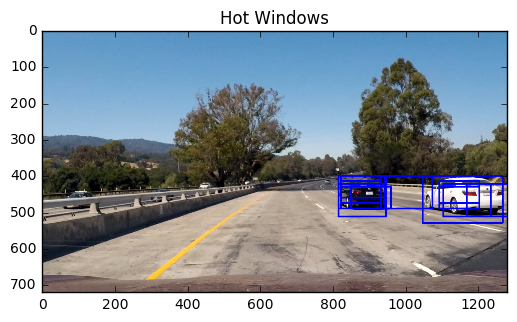

In [15]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='HSV', 
                    orient=9, pix_per_cell=8, cell_per_block=2, 
                    hog_channel='ALL', hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='HSV', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply 'HSV' color conversion
    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)  
    #3) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space,  
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=3)

plt.title('Hot Windows')
plt.imshow(window_img)

3 - The following cell unfortunately doesn't give a fair description of my actual process, but due to a few limitations, it's been a little simplified. In my actual processing of the image, I take into account the 10 frames before the current frame and compare all of them and then set a threshold based on this combined heatmap. For this example I simplified it, in the sense that I only used the current frame and showed somewhat of a threshold to give an idea of how the thresholding would work. The threshold set represents how many "hot" windows overlap. Apply a threshold and those "hot" windows which pass the threshold,  create a "heat" map for where all of them overlap. The output of that is the final image which gets overlayed onto the video. Please see my process_image function to get an actual look into how I set the thresholding.

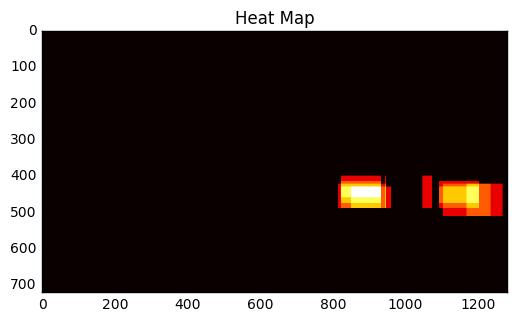

In [16]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,hot_windows)

# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

plt.title('Heat Map')
plt.imshow(heatmap, cmap='hot')

For my very first frame, my "previous" 10 frames are just and array of 720x1280 empty matrices. As the video progresses and as I pass more and more frames, I fill in my array with actual frames. Considering the frame rate is 30 frames/second (if I'm not mistaken), my array gets filled in less than a second. The threshold I used was one which I came up after much trial and error and found it worked best for me. The amount of frames I use in thresholding also came after much trial and error.

In [17]:
prev_heatmap = [np.zeros((720,1280)), 
                np.zeros((720,1280)), 
                np.zeros((720,1280)), 
                np.zeros((720,1280)), 
                np.zeros((720,1280)),
                np.zeros((720,1280)),
                np.zeros((720,1280)),
                np.zeros((720,1280)),
                np.zeros((720,1280)),
                np.zeros((720,1280))]

def set_prev_heatmap(heatmap, pos):
    global prev_heatmap
    prev_heatmap[pos] = heatmap
    
def get_prev_heatmap(pos):
    global prev_heatmap
    return prev_heatmap[pos]

In [18]:
def process_image(image):
    draw_image = np.copy(image)
    windows = slide_window(image, x_start_stop=[740, 1275], y_start_stop=[400, 460], 
                    xy_window=(110, 60), xy_overlap=(0.75, 0.75))   
    windows += slide_window(image, x_start_stop=[750, 1275], y_start_stop=[400, 490], 
                    xy_window=(130, 90), xy_overlap=(0.75, 0.75))
    windows += slide_window(image, x_start_stop=[825, 1275], y_start_stop=[400, 600], 
                    xy_window=(220, 130), xy_overlap=(0.5, 0.5))
    windows += slide_window(image, x_start_stop=[800, 1275], y_start_stop=[400, 650], 
                    xy_window=(400, 220), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space,  
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, hog_feat=hog_feat)                      
    
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    orig_heat = add_heat(heat,hot_windows)
        
    # Apply threshold to help remove false positives
    heat = apply_threshold((orig_heat+get_prev_heatmap(0)+get_prev_heatmap(1)+get_prev_heatmap(2)+get_prev_heatmap(3)+get_prev_heatmap(4)+get_prev_heatmap(5)+get_prev_heatmap(6)+get_prev_heatmap(7)+get_prev_heatmap(8)+get_prev_heatmap(9)),20)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    set_prev_heatmap(get_prev_heatmap(1), 0)
    set_prev_heatmap(get_prev_heatmap(2), 1)
    set_prev_heatmap(get_prev_heatmap(3), 2)
    set_prev_heatmap(get_prev_heatmap(4), 3)
    set_prev_heatmap(get_prev_heatmap(5), 4)
    set_prev_heatmap(get_prev_heatmap(6), 5)
    set_prev_heatmap(get_prev_heatmap(7), 6)
    set_prev_heatmap(get_prev_heatmap(8), 7)
    set_prev_heatmap(get_prev_heatmap(9), 8)
    set_prev_heatmap(orig_heat, 9)
    return draw_img

In [19]:
output = 'C:\\Users\\Syed\\Documents\\Proj5\\test_completed.mp4'
clip2 = VideoFileClip('C:\\Users\\Syed\\Documents\\Proj5\\test_video.mp4')
clip = clip2.fl_image(process_image)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video C:\Users\Syed\Documents\Proj5\test_completed.mp4
[MoviePy] Writing video C:\Users\Syed\Documents\Proj5\test_completed.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:24<00:00,  1.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: C:\Users\Syed\Documents\Proj5\test_completed.mp4 

Wall time: 26.6 s


<h2>Discussion</h2>
A few short comings of this project is that I completely ignored the cars on the on coming side of the road and I also assumed that there were no cars directly ahead of me. Along with that, my surrounding boxes were very shaky. Due to the constraint in time, I was not able to fulfill that. One more short coming for my project is that I cheated and declared global variables.

To improve on this project, I could take into account the above stated shortcomings and I could have also added lane lines. I also trained the classifier on a relatively small amount of car/not car images. A better classifier would take many more images into account (such as those larger datasets labeled/provided by Udacity). Another aspect was that this project was very binary (i.e. car and not car). A more realistic project would have more categories to it (such as: car, truck, motorcycle, pedestrian, etc.).

Overall though, I feel this was a good first attempt at something like this, considering I've never done this before =).